# **Homework 6 - Transformer**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/21 Updates)
1. Link to reference [training curves](https://wandb.ai/george0828zhang/hw5.seq2seq.new).

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [1]:
# !pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
# !pip install --upgrade jupyter ipywidgets

In [2]:
# !git clone https://github.com/pytorch/fairseq.git
# !cd fairseq && git checkout 9a1c497
# !pip install --upgrade ./fairseq/

In [2]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
# import tqdm.auto as tqdm
# from tqdm.notebook import tqdm
from tqdm import tqdm_notebook as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt
import inspect


# 設定種子

In [4]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

### 安裝megatools (optional)

In [5]:
# !apt-get install megatools

## 下載檔案並解壓縮

In [6]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    # '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    # '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
    "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
    "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
        
# already process        
# !mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
# !mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
# !mv {prefix/'test.en'} {prefix/'test.raw.en'}
# !mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

raw.en
raw.zh
test.en
test.zh


## 設定語言

In [7]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

指令名稱：head

功能說明：head指令會讀取所給予檔案的內容，並將其內容的最前面部份作標準輸出。預設為10行。

語法：head [options] file

[options]

-c：--bytes=N 指定輸出開頭的 "N" 個字元組。

-n：--lines=N 指定輸出開頭的 "N" 行。

-q： --quiet, --silent 不輸出檔案名稱的標頭。

-v：一定顯示含有檔案名稱的標頭。

範例：

1.列出fileA最前面10行內容
#head fileA

2.列出fileA最前面20列內容
#head -n 20 fileA

3.列出檔案fileA最前面200Bytes內容
#head -c 200 fileA

In [8]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [54]:
from prepare_data import strQ2B, clean_s, len_s, clean_corpus

lines = inspect.getsource(strQ2B)
print(lines)

lines = inspect.getsource(clean_s)
print(lines)

lines = inspect.getsource(len_s)
print(lines)

lines = inspect.getsource(clean_corpus)
print(lines)

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)

def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s =

In [10]:
# already process   
# clean_corpus(data_prefix, src_lang, tgt_lang)
# clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [11]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [12]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [13]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

train/valid splits exists. skipping split.


## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

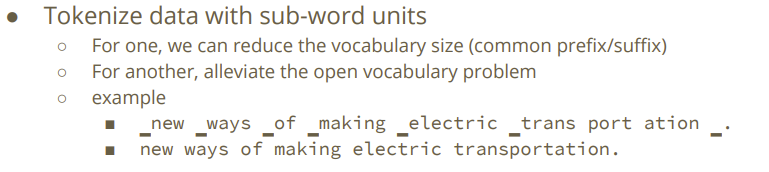


In [14]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/spm8000.model exists. skipping spm_train.


In [15]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}

# already process   
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/train.en exists. skipping spm_encode.
/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/train.zh exists. skipping spm_encode.
/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/valid.en exists. skipping spm_encode.
/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/valid.zh exists. skipping spm_encode.
/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/test.en exists. skipping spm_encode.
/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/ted2020/test.zh exists. skipping spm_encode.


In [16]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl ow n ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁。 ▁我 非常 感 激 ▁。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對我 之前 演講 的 好 評 ▁。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁!
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁!


## 用 fairseq 將資料轉為 binary

In [17]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

DATA/data-bin/ted2020 exists, will not overwrite!


# 實驗的參數設定表

In [18]:
from cfg import config 
print(config)

Namespace(accum_steps=2, beam=5, clip_norm=1.0, datadir='./DATA/data-bin/ted2020', keep_last_epochs=5, lr_factor=2.0, lr_warmup=4000, max_epoch=30, max_len_a=1.2, max_len_b=10, max_tokens=8192, num_workers=2, post_process='sentencepiece', python_path='/home/leyan/anaconda3/envs/torch_1_21/bin/python', resume=None, savedir='./checkpoints/transformer', source_lang='en', start_epoch=1, target_lang='zh', use_wandb=False)


# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [19]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [20]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2022-09-27 12:02:40 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-09-27 12:02:40 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 7.794 GB ; name = NVIDIA GeForce RTX 2080 SUPER           
2022-09-27 12:02:40 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [21]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2022-09-27 12:02:40 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-09-27 12:02:40 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [22]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2022-09-27 12:02:40 | INFO | hw5.seq2seq | loading data for epoch 1
2022-09-27 12:02:40 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2022-09-27 12:02:40 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2022-09-27 12:02:40 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train en-zh 390041 examples
2022-09-27 12:02:40 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2022-09-27 12:02:40 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2022-09-27 12:02:40 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid en-zh 3939 examples


In [23]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  24,   63,    5,  179,  435,  217,    6,   29,   41,    5, 1881,   52,
         252,  166,   60,  173,  132,  495,  605,  422,    6,  146,    6,   48,
           4,   11,  236,   24,  242,   54, 2671,    5,  257,  316,    6,   12,
        1351,  143,  103,    7,    2]),
 'target': tensor([ 161,  118,  297, 1528,  563,  129, 2997,  380,  612, 1159, 2710,  329,
        2529, 1406,  475,    4,    5,  650, 3835,  239,  303,   93, 2790, 1406,
         475,    9, 1192,   10,    2])}
('Source: you can very precisely calculate what your co2 emissions are , and '
 'then you will be given options to reduce .')
'Target: 你能非常精確地計算什麼你的二氧化碳排放 , 然后將給你減少排放的選擇 。'


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [24]:
from data import load_data_iterator
lines = inspect.getsource(load_data_iterator)
print(lines)


demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

2022-09-27 12:02:40 | WARNING | fairseq.tasks.fairseq_task | 2,542 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[815, 1267, 751, 349, 1996, 2330, 1750, 3867, 2838, 3747]


{'id': tensor([3586]),
 'nsentences': 1,
 'ntokens': 10,
 'net_input': {'src_tokens': tensor([[  1,   1, 126, 285,  77,   8,  13,  23, 272, 491,   6,  29, 203,   6,
             7,   2]]),
  'src_lengths': tensor([14]),
  'prev_output_tokens': tensor([[   2,    5, 1745, 4205, 4205,  445, 1664, 1636,  139,  315,    1,    1,
              1,    1,    1,    1]])},
 'target': tensor([[   5, 1745, 4205, 4205,  445, 1664, 1636,  139,  315,    2,    1,    1,
             1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [25]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Encoder 編碼器

- seq2seq 模型的編碼器為 RNN 或 Transformer Encoder，以下說明以 RNN 為例，Transformer 略有不同。對於每個輸入，Encoder 會輸出一個向量和一個隱藏狀態(hidden state)，並將隱藏狀態用於下一個輸入。換句話說，Encoder 會逐步讀取輸入序列，並在每個 timestep 輸出單個向量，以及在最後 timestep 輸出最終隱藏狀態(content vector)
- 參數:
  - *args*
      - encoder_embed_dim 是 embedding 的維度，主要將 one-hot vector 的單詞向量壓縮到指定的維度，主要是為了降維和濃縮資訊的功用
      - encoder_ffn_embed_dim 是 RNN 輸出和隱藏狀態的維度(hidden dimension)
      - encoder_layers 是 RNN 要疊多少層
      - dropout 是決定有多少的機率會將某個節點變為 0，主要是為了防止 overfitting ，一般來說是在訓練時使用，測試時則不使用
  - *dictionary*: fairseq 幫我們做好的 dictionary. 在此用來得到 padding index，好用來得到 encoder padding mask. 
  - *embed_tokens*: 事先做好的詞嵌入 (nn.Embedding)

- 輸入: 
    - *src_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 
- 輸出: 
    - *outputs*: 最上層 RNN 每個 timestep 的輸出，後續可以用 Attention 再進行處理
    - *final_hiddens*: 每層最終 timestep 的隱藏狀態，將傳遞到 Decoder 進行解碼
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。


In [26]:
from model import RNNEncoder
lines = inspect.getsource(RNNEncoder)
print(lines)

class RNNEncoder(FairseqEncoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        self.embed_dim = args.encoder_embed_dim
        self.hidden_dim = args.encoder_ffn_embed_dim
        self.num_layers = args.encoder_layers
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
            batch_first=False, 
            bidirectional=True
        )
        self.dropout_out_module = nn.Dropout(args.dropout)
        
        self.padding_idx = dictionary.pad()
        
    def combine_bidir(self, outs, bsz: int):
        out = outs.view(self.num_layers, 2, bsz, -1).transpose(1, 2).contiguous()
        return out.view(self.num_layers, bsz, -1)

    def forward(self, src_tokens, **unused):
        bsz, seqlen = src_tokens.size()
 

## Attention

- 當輸入過長，或是單獨靠 “content vector” 無法取得整個輸入的意思時，用 Attention Mechanism 來提供 Decoder 更多的資訊
- 根據現在 **Decoder embeddings** ，去計算在 **Encoder outputs** 中，那些與其有較高的關係，根據關係的數值來把 Encoder outputs 平均起來作為 **Decoder** RNN 的輸入 
- 常見 Attention 的實作是用 Neural Network / Dot Product 來算 **query** (decoder embeddings) 和 **key** (Encoder outputs) 之間的關係，再對所有算出來的數值做 **softmax** 得到分佈，最後根據這個分佈對 **values** (Encoder outputs) 做 **weight sum**

- 參數:
  - *input_embed_dim*: key 的維度，應是 decoder 要做 attend 時的向量的維度
  - *source_embed_dim*: query 的維度，應是要被 attend 的向量(encoder outputs)的維度
  - *output_embed_dim*: value 的維度，應是做完 attention 後，下一層預期的向量維度

- 輸入: 
    - *inputs*: 就是 key，要 attend 別人的向量
    - *encoder_outputs*: 是 query/value，被 attend 的向量
    - *encoder_padding_mask*: 告訴我們哪些是位置的資訊不重要。
- 輸出: 
    - *output*: 做完 attention 後的 context vector
    - *attention score*: attention 的分布


In [27]:
from attn import AttentionLayer
lines = inspect.getsource(AttentionLayer)
print(lines)

class AttentionLayer(nn.Module):
    def __init__(self, input_embed_dim, source_embed_dim, output_embed_dim, bias=False):
        super().__init__()

        self.input_proj = nn.Linear(input_embed_dim, source_embed_dim, bias=bias)
        self.output_proj = nn.Linear(
            input_embed_dim + source_embed_dim, output_embed_dim, bias=bias
        )

    def forward(self, inputs, encoder_outputs, encoder_padding_mask):
        # inputs: T, B, dim
        # encoder_outputs: S x B x dim
        # padding mask:  S x B
        
        # convert all to batch first
        inputs = inputs.transpose(1,0) # B, T, dim
        encoder_outputs = encoder_outputs.transpose(1,0) # B, S, dim
        encoder_padding_mask = encoder_padding_mask.transpose(1,0) # B, S
        
        # 投影到encoder_outputs的維度
        x = self.input_proj(inputs)

        # 計算attention
        # (B, T, dim) x (B, dim, S) = (B, T, S)
        attn_scores = torch.bmm(x, encoder_outputs.transpose(1,2))

        # 擋住padding

## Decoder 解碼器

* 解碼器的 hidden states 會用編碼器最終隱藏狀態來初始化(content vector)
* 解碼器同時也根據目前 timestep 的輸入(也就是前幾個 timestep 的 output)，改變 hidden states，並輸出結果 
* 如果加入 attention 可以使表現更好
* 我們把 seq2seq 步驟寫在解碼器裡，好讓等等 Seq2Seq 這個型別可以通用 RNN 和 Transformer，而不用再改寫
- 參數:
  - *args*
      - decoder_embed_dim 是解碼器 embedding 的維度，類同 encoder_embed_dim，
      - decoder_ffn_embed_dim 是解碼器 RNN 的隱藏維度，類同 encoder_ffn_embed_dim
      - decoder_layers 解碼器 RNN 的層數
      - share_decoder_input_output_embed 通常 decoder 最後輸出的投影矩陣會和輸入 embedding 共用參數
  - *dictionary*: fairseq 幫我們做好的 dictionary.
  - *embed_tokens*: 事先做好的詞嵌入(nn.Embedding)
- 輸入: 
    - *prev_output_tokens*: 英文的整數序列 e.g. 1, 28, 29, 205, 2 已經 shift 一格的 target
    - *encoder_out*: 編碼器的輸出
    - *incremental_state*: 這是測試階段為了加速，所以會記錄每個 timestep 的 hidden state 詳見 forward
- 輸出: 
    - *outputs*: decoder 每個 timestep 的 logits，還沒經過 softmax 的分布
    - *extra*: 沒用到

In [28]:
from model import RNNDecoder
lines = inspect.getsource(RNNDecoder)
print(lines)

class RNNDecoder(FairseqIncrementalDecoder):
    def __init__(self, args, dictionary, embed_tokens):
        super().__init__(dictionary)
        self.embed_tokens = embed_tokens
        
        assert args.decoder_layers == args.encoder_layers, f"""seq2seq rnn requires that encoder 
        and decoder have same layers of rnn. got: {args.encoder_layers, args.decoder_layers}"""
        assert args.decoder_ffn_embed_dim == args.encoder_ffn_embed_dim*2, f"""seq2seq-rnn requires 
        that decoder hidden to be 2*encoder hidden dim. got: {args.decoder_ffn_embed_dim, args.encoder_ffn_embed_dim*2}"""
        
        self.embed_dim = args.decoder_embed_dim
        self.hidden_dim = args.decoder_ffn_embed_dim
        self.num_layers = args.decoder_layers
        
        
        self.dropout_in_module = nn.Dropout(args.dropout)
        self.rnn = nn.GRU(
            self.embed_dim, 
            self.hidden_dim, 
            self.num_layers, 
            dropout=args.dropout, 
           

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [29]:
from model import Seq2Seq
lines = inspect.getsource(Seq2Seq)
print(lines)

class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra



# 模型初始化

In [30]:
from model import build_model_transformer as build_model
lines = inspect.getsource(build_model)
print(lines)

def build_model_transformer(args, task):

    add_transformer_args(medium_arch_args)    

    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Em

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [31]:
from model import add_transformer_args
lines = inspect.getsource(add_transformer_args)
print(lines)

# medium
arch_args = medium_arch_args = Namespace(
    encoder_embed_dim=256,
    encoder_ffn_embed_dim=512,
    encoder_layers=4,
    decoder_embed_dim=256,
    decoder_ffn_embed_dim=1024,
    decoder_layers=4,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

add_transformer_args(arch_args)

def add_transformer_args(args):
    args.encoder_attention_heads=4
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=4
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(args)

    args.encoder_layers = 4
    args.decoder_layers = 4
    args.encoder_ffn_embed_dim=1024



In [32]:
arch_args

Namespace(activation_dropout=0.0, activation_fn='relu', adaptive_input=False, adaptive_softmax_cutoff=None, adaptive_softmax_dropout=0, attention_dropout=0.0, checkpoint_activations=False, cross_self_attention=False, decoder_attention_heads=4, decoder_embed_dim=256, decoder_embed_path=None, decoder_ffn_embed_dim=1024, decoder_input_dim=256, decoder_layerdrop=0, decoder_layers=4, decoder_layers_to_keep=None, decoder_learned_pos=False, decoder_normalize_before=True, decoder_output_dim=256, dropout=0.3, encoder_attention_heads=4, encoder_embed_dim=256, encoder_embed_path=None, encoder_ffn_embed_dim=1024, encoder_layerdrop=0, encoder_layers=4, encoder_layers_to_keep=None, encoder_learned_pos=False, encoder_normalize_before=True, layernorm_embedding=False, max_source_positions=1024, max_target_positions=1024, no_cross_attention=False, no_scale_embedding=False, no_token_positional_embeddings=False, quant_noise_pq=0, quant_noise_pq_block_size=8, quant_noise_scalar=0, share_all_embeddings=Fals

In [33]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [34]:
model = build_model(arch_args, task)
logger.info(model)

2022-09-27 12:02:40 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 256, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=256, out_features=256, bias=True)
          (v_proj): Linear(in_features=256, out_features=256, bias=True)
          (q_proj): Linear(in_features=256, out_features=256, bias=True)
          (out_proj): Linear(in_features=256, out_features=256, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=256, out_features=1024, bias=True)
        (fc2): Linear(in_features=1024, out_features=256, bia

## baseline
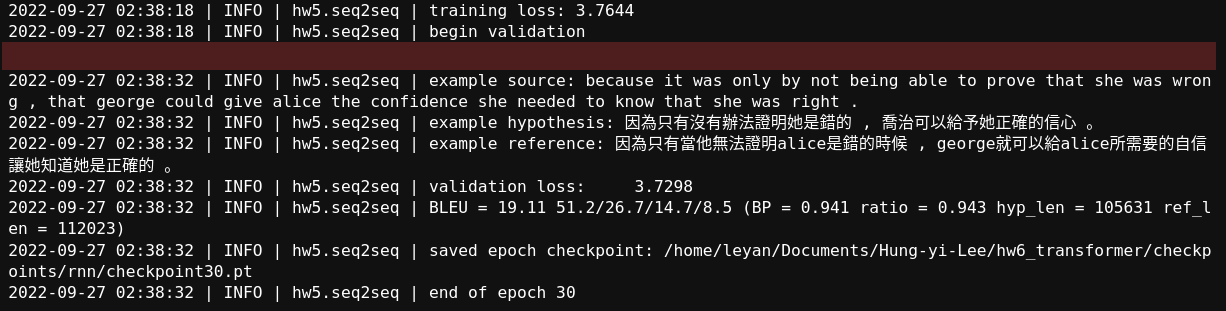

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [35]:
from loss import LabelSmoothedCrossEntropyCriterion
lines = inspect.getsource(LabelSmoothedCrossEntropyCriterion)
print(lines)

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_l

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [36]:
from optimizer import NoamOpt
lines = inspect.getsource(NoamOpt)
print(lines)

class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            

## 排程視覺化

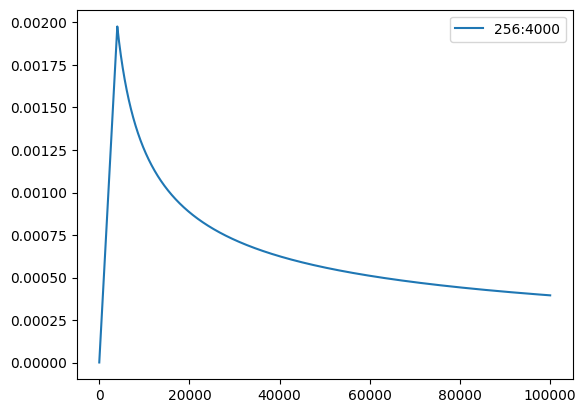

In [37]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [38]:
from train_script import train_one_epoch

from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

lines = inspect.getsource(train_one_epoch)
print(lines)

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1, logger=None):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [39]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

from inference_script import decode, inference_step

lines = inspect.getsource(decode)
print(lines)

lines = inspect.getsource(inference_step)
print(lines)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model, sequence_generator=None, task=None):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs



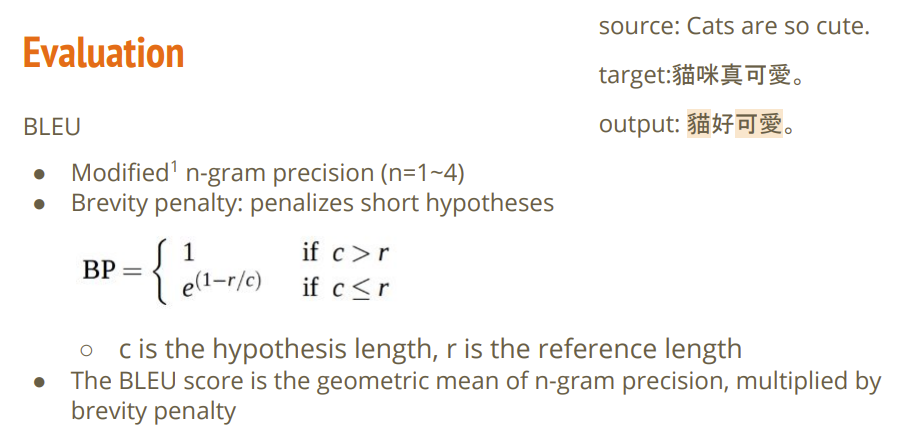

In [40]:
import shutil
import sacrebleu

from valid_script import validate

lines = inspect.getsource(validate)
print(lines)

def validate(model, task, criterion, sequence_generator=None, logger=None, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
    

# 儲存及載入模型參數

In [41]:
from utils import validate_and_save, try_load_checkpoint

lines = inspect.getsource(validate_and_save)
print(lines)

lines = inspect.getsource(try_load_checkpoint)
print(lines)

def validate_and_save(model, task, criterion, optimizer, epoch, save=True, sequence_generator=None, logger=None):   
    stats = validate(model, task, criterion, sequence_generator, logger)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
              

# 主程式 (main.py)
## 訓練迴圈

In [42]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [43]:
!nvidia-smi

Tue Sep 27 12:02:41 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 50%   60C    P2    56W / 250W |   1478MiB /  7981MiB |     22%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [44]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2022-09-27 12:02:42 | INFO | hw5.seq2seq | task: TranslationTask
2022-09-27 12:02:42 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2022-09-27 12:02:42 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2022-09-27 12:02:42 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2022-09-27 12:02:42 | INFO | hw5.seq2seq | optimizer: NoamOpt
2022-09-27 12:02:42 | INFO | hw5.seq2seq | num. model params: 11,469,824 (num. trained: 11,469,824)
2022-09-27 12:02:42 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [45]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume, logger=logger)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps, logger=logger)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch, sequence_generator=sequence_generator, logger=logger)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2022-09-27 12:02:42 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326651]
2022-09-27 12:02:42 | INFO | hw5.seq2seq | loaded checkpoint checkpoints/transformer/checkpoint_last.pt: step=778 loss=5.9944257736206055 bleu=0.8617376660763251


2022-09-27 12:04:38 | INFO | hw5.seq2seq | training loss: 5.5349
2022-09-27 12:04:38 | INFO | hw5.seq2seq | begin validation


validation:   0%|                            | 0/23 [00:00<?, ?it/s, valid_loss=4.1]/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/fairseq/search.py:140: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  beams_buf = indices_buf // vocab_size
/home/leyan/anaconda3/envs/torch_1_21/lib/python3.8/site-packages/fairseq/sequence_generator.py:657: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for a

2022-09-27 12:04:56 | INFO | hw5.seq2seq | example source: we shouldn't overvalue stem .
2022-09-27 12:04:56 | INFO | hw5.seq2seq | example hypothesis: 我們應該在大麻麻麻麻麻煩 。
2022-09-27 12:04:56 | INFO | hw5.seq2seq | example reference: 我們不應該過度重視stem 。
2022-09-27 12:04:56 | INFO | hw5.seq2seq | validation loss:	4.9911
2022-09-27 12:04:56 | INFO | hw5.seq2seq | BLEU = 7.90 35.4/13.3/5.4/2.2 (BP = 0.916 ratio = 0.919 hyp_len = 102994 ref_len = 112023)
2022-09-27 12:04:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint1.pt
2022-09-27 12:04:56 | INFO | hw5.seq2seq | end of epoch 1


2022-09-27 12:06:50 | INFO | hw5.seq2seq | training loss: 4.9193
2022-09-27 12:06:50 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:07:08 | INFO | hw5.seq2seq | example source: well she was back all right .
2022-09-27 12:07:08 | INFO | hw5.seq2seq | example hypothesis: 她回來了 。
2022-09-27 12:07:08 | INFO | hw5.seq2seq | example reference: 好吧 , 她回來了
2022-09-27 12:07:08 | INFO | hw5.seq2seq | validation loss:	4.5440
2022-09-27 12:07:08 | INFO | hw5.seq2seq | BLEU = 11.70 44.7/19.7/9.3/4.6 (BP = 0.838 ratio = 0.850 hyp_len = 95176 ref_len = 112023)
2022-09-27 12:07:09 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint2.pt
2022-09-27 12:07:09 | INFO | hw5.seq2seq | end of epoch 2


2022-09-27 12:09:02 | INFO | hw5.seq2seq | training loss: 4.5959
2022-09-27 12:09:02 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:09:23 | INFO | hw5.seq2seq | example source: we had basically three requirements .
2022-09-27 12:09:23 | INFO | hw5.seq2seq | example hypothesis: 我們基本上有三個需要 。
2022-09-27 12:09:23 | INFO | hw5.seq2seq | example reference: 基本上我們有三個需求
2022-09-27 12:09:23 | INFO | hw5.seq2seq | validation loss:	4.2640
2022-09-27 12:09:23 | INFO | hw5.seq2seq | BLEU = 14.32 48.4/23.0/11.7/6.2 (BP = 0.849 ratio = 0.860 hyp_len = 96308 ref_len = 112023)
2022-09-27 12:09:23 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint3.pt
2022-09-27 12:09:23 | INFO | hw5.seq2seq | end of epoch 3


2022-09-27 12:11:16 | INFO | hw5.seq2seq | training loss: 4.3878
2022-09-27 12:11:16 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:11:37 | INFO | hw5.seq2seq | example source: and while a more recent study did show that reaction times and errors increase for some bilingual students in crosslanguage tests , it also showed that the effort and attention needed to switch between languages triggered more activity in , and potentially strengthened , the dorsolateral prefrontal cortex .
2022-09-27 12:11:37 | INFO | hw5.seq2seq | example hypothesis: 雖然更近期的研究顯示 , 報告顯示 , 報導越來越多的學生 , 同時也顯示 , 值得更開心的語言 , 更可能是有能力的學生 。
2022-09-27 12:11:37 | INFO | hw5.seq2seq | example reference: 最新的硏究顯示 , 在跨語言測驗當中 , 使用雙語學生的反應時間與錯誤次數增加了這個結果顯示 , 學生需要更努力與專注於轉換語言 , 這也使得前額葉腦區不僅更加活躍 , 而且能強化它的功能 。
2022-09-27 12:11:37 | INFO | hw5.seq2seq | validation loss:	4.1236
2022-09-27 12:11:37 | INFO | hw5.seq2seq | BLEU = 16.46 50.1/24.6/12.8/7.0 (BP = 0.903 ratio = 0.907 hyp_len = 101648 ref_len = 112023)
2022-09-27 12:11:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/ch

2022-09-27 12:13:31 | INFO | hw5.seq2seq | training loss: 4.2407
2022-09-27 12:13:31 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:13:50 | INFO | hw5.seq2seq | example source: he was a wonderful inventor , a maverick creator .
2022-09-27 12:13:50 | INFO | hw5.seq2seq | example hypothesis: 他是個很棒的發明家 , 一個很棒的創作家 。
2022-09-27 12:13:50 | INFO | hw5.seq2seq | example reference: 他是位很棒的發明家 , 獨排眾議的創造家 。
2022-09-27 12:13:50 | INFO | hw5.seq2seq | validation loss:	3.9971
2022-09-27 12:13:50 | INFO | hw5.seq2seq | BLEU = 17.02 53.7/27.1/14.5/8.2 (BP = 0.834 ratio = 0.846 hyp_len = 94784 ref_len = 112023)
2022-09-27 12:13:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint5.pt
2022-09-27 12:13:50 | INFO | hw5.seq2seq | end of epoch 5


2022-09-27 12:15:43 | INFO | hw5.seq2seq | training loss: 4.1116
2022-09-27 12:15:43 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:16:04 | INFO | hw5.seq2seq | example source: just saying .
2022-09-27 12:16:04 | INFO | hw5.seq2seq | example hypothesis: 只是說 。
2022-09-27 12:16:04 | INFO | hw5.seq2seq | example reference: 說說而已 。
2022-09-27 12:16:04 | INFO | hw5.seq2seq | validation loss:	3.8852
2022-09-27 12:16:04 | INFO | hw5.seq2seq | BLEU = 19.02 52.3/26.8/14.5/8.2 (BP = 0.943 ratio = 0.945 hyp_len = 105824 ref_len = 112023)
2022-09-27 12:16:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint6.pt
2022-09-27 12:16:04 | INFO | hw5.seq2seq | end of epoch 6


2022-09-27 12:17:58 | INFO | hw5.seq2seq | training loss: 4.0215
2022-09-27 12:17:58 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:18:15 | INFO | hw5.seq2seq | example source: thank you .
2022-09-27 12:18:15 | INFO | hw5.seq2seq | example hypothesis: 感謝 。
2022-09-27 12:18:15 | INFO | hw5.seq2seq | example reference: 謝謝
2022-09-27 12:18:15 | INFO | hw5.seq2seq | validation loss:	3.8283
2022-09-27 12:18:15 | INFO | hw5.seq2seq | BLEU = 18.89 56.2/29.4/16.2/9.3 (BP = 0.845 ratio = 0.856 hyp_len = 95921 ref_len = 112023)
2022-09-27 12:18:15 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint7.pt
2022-09-27 12:18:15 | INFO | hw5.seq2seq | end of epoch 7


2022-09-27 12:20:09 | INFO | hw5.seq2seq | training loss: 3.9483
2022-09-27 12:20:09 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:20:28 | INFO | hw5.seq2seq | example source: i climbed higher , higher , higher , and i jumped .
2022-09-27 12:20:28 | INFO | hw5.seq2seq | example hypothesis: 我爬得更高 , 更高 , 我跳下去 。
2022-09-27 12:20:28 | INFO | hw5.seq2seq | example reference: 我越爬越高 , 越爬越高 , 然後我跳了 。
2022-09-27 12:20:28 | INFO | hw5.seq2seq | validation loss:	3.7574
2022-09-27 12:20:28 | INFO | hw5.seq2seq | BLEU = 19.95 56.2/29.8/16.6/9.7 (BP = 0.874 ratio = 0.882 hyp_len = 98764 ref_len = 112023)
2022-09-27 12:20:28 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint8.pt
2022-09-27 12:20:29 | INFO | hw5.seq2seq | end of epoch 8


2022-09-27 12:22:22 | INFO | hw5.seq2seq | training loss: 3.8935
2022-09-27 12:22:22 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:22:42 | INFO | hw5.seq2seq | example source: but i also loved the arts and sciences .
2022-09-27 12:22:42 | INFO | hw5.seq2seq | example hypothesis: 但我也喜歡藝術和科學 。
2022-09-27 12:22:42 | INFO | hw5.seq2seq | example reference: 當我還是個小女孩
2022-09-27 12:22:42 | INFO | hw5.seq2seq | validation loss:	3.7324
2022-09-27 12:22:42 | INFO | hw5.seq2seq | BLEU = 20.71 54.8/29.1/16.1/9.4 (BP = 0.935 ratio = 0.937 hyp_len = 104956 ref_len = 112023)
2022-09-27 12:22:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint9.pt
2022-09-27 12:22:42 | INFO | hw5.seq2seq | end of epoch 9


2022-09-27 12:24:36 | INFO | hw5.seq2seq | training loss: 3.8512
2022-09-27 12:24:36 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:24:56 | INFO | hw5.seq2seq | example source: in one of the joints between over 9 , 000 magnets in lhc , there was a manufacturing defect .
2022-09-27 12:24:56 | INFO | hw5.seq2seq | example hypothesis: 在lhc中 , 有超過9 , 000個磁鐵之間 , 有一種製造性的偵測 。
2022-09-27 12:24:56 | INFO | hw5.seq2seq | example reference: 在lhc里九千多個磁鐵的其中一個結合處會有製成不良
2022-09-27 12:24:56 | INFO | hw5.seq2seq | validation loss:	3.6997
2022-09-27 12:24:56 | INFO | hw5.seq2seq | BLEU = 20.98 56.1/30.1/16.8/9.9 (BP = 0.910 ratio = 0.914 hyp_len = 102406 ref_len = 112023)
2022-09-27 12:24:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint10.pt
2022-09-27 12:24:56 | INFO | hw5.seq2seq | end of epoch 10


2022-09-27 12:26:50 | INFO | hw5.seq2seq | training loss: 3.8182
2022-09-27 12:26:50 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:27:10 | INFO | hw5.seq2seq | example source: the passengers on the second bus are assigned powers of the next prime , 5 .
2022-09-27 12:27:10 | INFO | hw5.seq2seq | example hypothesis: 第二個公車的乘客被移除了下一個主要的權力 , 5 。
2022-09-27 12:27:10 | INFO | hw5.seq2seq | example reference: 第二輛巴士上的客人所各自入住的房號則是下一個質數5的座號次方
2022-09-27 12:27:10 | INFO | hw5.seq2seq | validation loss:	3.6697
2022-09-27 12:27:10 | INFO | hw5.seq2seq | BLEU = 21.61 55.0/29.4/16.4/9.6 (BP = 0.962 ratio = 0.962 hyp_len = 107805 ref_len = 112023)
2022-09-27 12:27:10 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint11.pt
2022-09-27 12:27:10 | INFO | hw5.seq2seq | end of epoch 11


2022-09-27 12:29:04 | INFO | hw5.seq2seq | training loss: 3.7877
2022-09-27 12:29:04 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:29:24 | INFO | hw5.seq2seq | example source: for instance , you see the spectral line of the gold is the only spectral line in the spectrum of the sun .
2022-09-27 12:29:24 | INFO | hw5.seq2seq | example hypothesis: 舉例來說 , 你可以看到黃色的光譜是太陽光譜中唯一的光譜線 。
2022-09-27 12:29:24 | INFO | hw5.seq2seq | example reference: 譬如說你看到金的光譜線是太陽光譜裡面唯一的一條線 。
2022-09-27 12:29:24 | INFO | hw5.seq2seq | validation loss:	3.6357
2022-09-27 12:29:24 | INFO | hw5.seq2seq | BLEU = 21.82 56.0/30.3/17.1/10.1 (BP = 0.937 ratio = 0.939 hyp_len = 105206 ref_len = 112023)
2022-09-27 12:29:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint12.pt
2022-09-27 12:29:24 | INFO | hw5.seq2seq | end of epoch 12


2022-09-27 12:31:17 | INFO | hw5.seq2seq | training loss: 3.7608
2022-09-27 12:31:17 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:31:37 | INFO | hw5.seq2seq | example source: as i said , the inflection point where this has become really possible very embarrassing , my thesis was about machine learning .
2022-09-27 12:31:37 | INFO | hw5.seq2seq | example hypothesis: 如我所說的 , 感染的重點是機器學習 。
2022-09-27 12:31:37 | INFO | hw5.seq2seq | example reference: 如我所言 , 這件事的反轉點在於──很慚愧 , 我的論文主題是機器學習 ,
2022-09-27 12:31:37 | INFO | hw5.seq2seq | validation loss:	3.6395
2022-09-27 12:31:37 | INFO | hw5.seq2seq | BLEU = 20.95 58.5/31.8/18.0/10.6 (BP = 0.859 ratio = 0.868 hyp_len = 97203 ref_len = 112023)
2022-09-27 12:31:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint13.pt
2022-09-27 12:31:37 | INFO | hw5.seq2seq | end of epoch 13


2022-09-27 12:33:30 | INFO | hw5.seq2seq | training loss: 3.7393
2022-09-27 12:33:30 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:33:49 | INFO | hw5.seq2seq | example source: and when i went to the refugee camp in pakistan , there were 7 . 5 million refugees .
2022-09-27 12:33:49 | INFO | hw5.seq2seq | example hypothesis: 當我去巴基斯坦的難民營時 , 有750萬難民 。
2022-09-27 12:33:49 | INFO | hw5.seq2seq | example reference: 我跑去在巴基斯坦的難民營 , 那裡有750萬難民 。
2022-09-27 12:33:49 | INFO | hw5.seq2seq | validation loss:	3.6118
2022-09-27 12:33:49 | INFO | hw5.seq2seq | BLEU = 21.47 58.3/31.8/18.1/10.8 (BP = 0.875 ratio = 0.882 hyp_len = 98799 ref_len = 112023)
2022-09-27 12:33:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint14.pt
2022-09-27 12:33:49 | INFO | hw5.seq2seq | end of epoch 14


2022-09-27 12:35:42 | INFO | hw5.seq2seq | training loss: 3.7201
2022-09-27 12:35:42 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:36:00 | INFO | hw5.seq2seq | example source: below the skin's surface , the roots that give rise to our hair actually remain alive .
2022-09-27 12:36:00 | INFO | hw5.seq2seq | example hypothesis: 在皮膚的表面下 , 造成頭髮的根部還活著 。
2022-09-27 12:36:00 | INFO | hw5.seq2seq | example reference: 在皮膚表皮下方長出頭髮的髮根事實上還持續活著
2022-09-27 12:36:00 | INFO | hw5.seq2seq | validation loss:	3.5998
2022-09-27 12:36:00 | INFO | hw5.seq2seq | BLEU = 21.67 58.6/32.1/18.4/11.0 (BP = 0.873 ratio = 0.880 hyp_len = 98592 ref_len = 112023)
2022-09-27 12:36:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint15.pt
2022-09-27 12:36:00 | INFO | hw5.seq2seq | end of epoch 15


2022-09-27 12:37:54 | INFO | hw5.seq2seq | training loss: 3.7035
2022-09-27 12:37:54 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:38:11 | INFO | hw5.seq2seq | example source: but they get the information that causes them to stop , causes them to internalize that they need to make all of the various parts that will cause them to change their shape , and try to get out of this capillary and find out what's going on .
2022-09-27 12:38:11 | INFO | hw5.seq2seq | example hypothesis: 但他們得到這些導致他們停止的資訊 , 導致他們內在化 , 使他們能改變他們的形狀 , 試著找出發生了什麼事 。
2022-09-27 12:38:11 | INFO | hw5.seq2seq | example reference: 這個訊息讓它們停了下來 , 它們開始進行內化反應 , 它們必須製造許多不同的物件 , 因此它們必須改變外型 , 離開微血管 , 並搞清楚到底發生什麼事 。
2022-09-27 12:38:11 | INFO | hw5.seq2seq | validation loss:	3.5897
2022-09-27 12:38:11 | INFO | hw5.seq2seq | BLEU = 22.41 58.2/32.0/18.4/11.0 (BP = 0.903 ratio = 0.908 hyp_len = 101698 ref_len = 112023)
2022-09-27 12:38:11 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint16.pt
2022-09-27 12:38:11 | INFO | hw5.seq2seq | end of epoch 16


2022-09-27 12:40:04 | INFO | hw5.seq2seq | training loss: 3.6869
2022-09-27 12:40:04 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:40:25 | INFO | hw5.seq2seq | example source: it rose up . it sat there for five days .
2022-09-27 12:40:25 | INFO | hw5.seq2seq | example hypothesis: 牠爬上去 , 坐在那裡五天 。
2022-09-27 12:40:25 | INFO | hw5.seq2seq | example reference: 神廟建起來的五天後 ,
2022-09-27 12:40:25 | INFO | hw5.seq2seq | validation loss:	3.5713
2022-09-27 12:40:25 | INFO | hw5.seq2seq | BLEU = 22.81 56.3/30.8/17.6/10.6 (BP = 0.957 ratio = 0.957 hyp_len = 107253 ref_len = 112023)
2022-09-27 12:40:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint17.pt
2022-09-27 12:40:25 | INFO | hw5.seq2seq | end of epoch 17


2022-09-27 12:42:19 | INFO | hw5.seq2seq | training loss: 3.6707
2022-09-27 12:42:19 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:42:38 | INFO | hw5.seq2seq | example source: isn't that what we all need ?
2022-09-27 12:42:38 | INFO | hw5.seq2seq | example hypothesis: 我們都需要的不是嗎 ?
2022-09-27 12:42:38 | INFO | hw5.seq2seq | example reference: 那不是我們所有人都需要的嗎 ?
2022-09-27 12:42:38 | INFO | hw5.seq2seq | validation loss:	3.5768
2022-09-27 12:42:38 | INFO | hw5.seq2seq | BLEU = 22.20 57.8/31.6/18.1/10.8 (BP = 0.907 ratio = 0.911 hyp_len = 102044 ref_len = 112023)
2022-09-27 12:42:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint18.pt
2022-09-27 12:42:38 | INFO | hw5.seq2seq | end of epoch 18


2022-09-27 12:44:32 | INFO | hw5.seq2seq | training loss: 3.6581
2022-09-27 12:44:32 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:44:50 | INFO | hw5.seq2seq | example source: if you stimulate the spinal cord of a cat , you can switch between walk , trot and gallop .
2022-09-27 12:44:50 | INFO | hw5.seq2seq | example hypothesis: 如果你刺激一隻貓的脊髓 , 你可以轉換步行、特律和加坡 。
2022-09-27 12:44:50 | INFO | hw5.seq2seq | example reference: 如果你刺激一隻貓的脊髓 , 你能夠在其間切換模式:行走、緩跑和急步跑 。
2022-09-27 12:44:50 | INFO | hw5.seq2seq | validation loss:	3.5492
2022-09-27 12:44:50 | INFO | hw5.seq2seq | BLEU = 22.81 57.8/31.8/18.3/11.0 (BP = 0.923 ratio = 0.926 hyp_len = 103715 ref_len = 112023)
2022-09-27 12:44:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint19.pt
2022-09-27 12:44:50 | INFO | hw5.seq2seq | end of epoch 19


2022-09-27 12:46:46 | INFO | hw5.seq2seq | training loss: 3.6454
2022-09-27 12:46:46 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:47:06 | INFO | hw5.seq2seq | example source: experimental measurements show kolmogorov was remarkably close to the way turbulent flow works , although a complete description of turbulence remains one of the unsolved problems in physics .
2022-09-27 12:47:06 | INFO | hw5.seq2seq | example hypothesis: 實驗測量顯示科羅哥夫與土耳其流動的方式非常接近 , 雖然完全描述土耳其的混亂仍然是物理學中未解決的問題之一 。
2022-09-27 12:47:06 | INFO | hw5.seq2seq | example reference: 實驗數據證實柯爾莫哥洛夫的模型非常接近紊流的流動方式雖然紊流完整的解釋仍是物理學中一項待解的難題
2022-09-27 12:47:06 | INFO | hw5.seq2seq | validation loss:	3.5455
2022-09-27 12:47:06 | INFO | hw5.seq2seq | BLEU = 22.77 57.9/32.0/18.5/11.1 (BP = 0.917 ratio = 0.920 hyp_len = 103051 ref_len = 112023)
2022-09-27 12:47:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint20.pt
2022-09-27 12:47:06 | INFO | hw5.seq2seq | end of epoch 20


2022-09-27 12:49:06 | INFO | hw5.seq2seq | training loss: 3.6375
2022-09-27 12:49:06 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:49:24 | INFO | hw5.seq2seq | example source: i talked before about the use of devices to dramatically change the way we treat disease .
2022-09-27 12:49:24 | INFO | hw5.seq2seq | example hypothesis: 我之前談到裝置的使用 , 大幅改變我們治療疾病的方式 。
2022-09-27 12:49:24 | INFO | hw5.seq2seq | example reference: 我也提到過用精密儀器顛覆治療疾病的方式
2022-09-27 12:49:24 | INFO | hw5.seq2seq | validation loss:	3.5362
2022-09-27 12:49:24 | INFO | hw5.seq2seq | BLEU = 23.08 58.1/32.2/18.6/11.3 (BP = 0.922 ratio = 0.925 hyp_len = 103585 ref_len = 112023)
2022-09-27 12:49:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint21.pt
2022-09-27 12:49:24 | INFO | hw5.seq2seq | end of epoch 21


2022-09-27 12:51:22 | INFO | hw5.seq2seq | training loss: 3.6253
2022-09-27 12:51:22 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:51:41 | INFO | hw5.seq2seq | example source: and there's bomb threats .
2022-09-27 12:51:41 | INFO | hw5.seq2seq | example hypothesis: 還有炸彈威脅 。
2022-09-27 12:51:41 | INFO | hw5.seq2seq | example reference: 還有炸彈威脅 。
2022-09-27 12:51:41 | INFO | hw5.seq2seq | validation loss:	3.5402
2022-09-27 12:51:41 | INFO | hw5.seq2seq | BLEU = 23.14 57.7/31.9/18.4/11.2 (BP = 0.933 ratio = 0.935 hyp_len = 104735 ref_len = 112023)
2022-09-27 12:51:41 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint22.pt
2022-09-27 12:51:41 | INFO | hw5.seq2seq | end of epoch 22


2022-09-27 12:53:38 | INFO | hw5.seq2seq | training loss: 3.6147
2022-09-27 12:53:38 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:53:58 | INFO | hw5.seq2seq | example source: em: there actually are far more charging stations than people realize , and at tesla we developed something called a supercharging technology , and we're offering that if you buy a model s for free , forever .
2022-09-27 12:53:58 | INFO | hw5.seq2seq | example hypothesis: e........事實上 , 比人們意識到的還要多 , 在特斯拉 , 我們開發了一種叫做超級搜索科技的東西 , 我們推薦 , 如果你能自由 , 永遠買一個模型 。
2022-09-27 12:53:58 | INFO | hw5.seq2seq | example reference: e..事實上充電站比人們意識到的還要多得多 , e..事實上充電站比人們意識到的還要多得多 , 我們也為tesla設計了一項名為 「 超級充電科技 」 。 我們也為tesla設計了一項名為 「 超級充電科技 」 。 如果你買了一臺models , 我們將終身免費提供給你 。 如果你買了一臺models , 我們將終身免費提供給你 。
2022-09-27 12:53:58 | INFO | hw5.seq2seq | validation loss:	3.5310
2022-09-27 12:53:58 | INFO | hw5.seq2seq | BLEU = 22.83 58.1/32.0/18.4/11.2 (BP = 0.918 ratio = 0.921 hyp_len = 103192 ref_len = 112023)
2022-09-27 12:53:58 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint2

2022-09-27 12:55:52 | INFO | hw5.seq2seq | training loss: 3.6060
2022-09-27 12:55:52 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:56:12 | INFO | hw5.seq2seq | example source: i wasn't worried about the material i would teach because i was wellprepared , and i was going to teach what i enjoy teaching .
2022-09-27 12:56:12 | INFO | hw5.seq2seq | example hypothesis: 我不擔心我會教的材料 , 因為我已經準備好了 , 我將會教我享受的教學 。
2022-09-27 12:56:12 | INFO | hw5.seq2seq | example reference: 但不是擔心教材的問題 , 因為我的教材準備得很充分 , 而且我非常喜歡教書的工作 。
2022-09-27 12:56:12 | INFO | hw5.seq2seq | validation loss:	3.5525
2022-09-27 12:56:12 | INFO | hw5.seq2seq | BLEU = 23.54 57.0/31.5/18.3/11.0 (BP = 0.959 ratio = 0.960 hyp_len = 107568 ref_len = 112023)
2022-09-27 12:56:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint24.pt
2022-09-27 12:56:12 | INFO | hw5.seq2seq | end of epoch 24


2022-09-27 12:58:06 | INFO | hw5.seq2seq | training loss: 3.5976
2022-09-27 12:58:06 | INFO | hw5.seq2seq | begin validation


2022-09-27 12:58:25 | INFO | hw5.seq2seq | example source: when we think of mud , we think of dirt it's ugly , it's nondurable and this is the image i want to change .
2022-09-27 12:58:25 | INFO | hw5.seq2seq | example hypothesis: 當我們想到泥巴時 , 我們會想到泥土 , 很醜陋 , 這是我想要改變的圖片 。
2022-09-27 12:58:25 | INFO | hw5.seq2seq | example reference: 當我們想到泥巴時 , 我們會想到汙物──它很醜陋 , 它不耐久──我想要改變我們對泥巴的印象 。
2022-09-27 12:58:25 | INFO | hw5.seq2seq | validation loss:	3.5121
2022-09-27 12:58:25 | INFO | hw5.seq2seq | BLEU = 23.06 58.5/32.4/18.8/11.4 (BP = 0.913 ratio = 0.917 hyp_len = 102714 ref_len = 112023)
2022-09-27 12:58:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint25.pt
2022-09-27 12:58:26 | INFO | hw5.seq2seq | end of epoch 25


2022-09-27 13:00:19 | INFO | hw5.seq2seq | training loss: 3.5896
2022-09-27 13:00:19 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:00:39 | INFO | hw5.seq2seq | example source: i have xy chromosomes .
2022-09-27 13:00:39 | INFO | hw5.seq2seq | example hypothesis: 我有xy染色體 。
2022-09-27 13:00:39 | INFO | hw5.seq2seq | example reference: 我有xy染色體 。
2022-09-27 13:00:39 | INFO | hw5.seq2seq | validation loss:	3.5165
2022-09-27 13:00:39 | INFO | hw5.seq2seq | BLEU = 22.72 59.0/32.7/18.9/11.4 (BP = 0.895 ratio = 0.900 hyp_len = 100816 ref_len = 112023)
2022-09-27 13:00:39 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint26.pt
2022-09-27 13:00:39 | INFO | hw5.seq2seq | end of epoch 26


2022-09-27 13:02:33 | INFO | hw5.seq2seq | training loss: 3.5829
2022-09-27 13:02:33 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:02:52 | INFO | hw5.seq2seq | example source: but i also learned very soon thereafter that jesus also said , and i'm paraphrasing , the poor would always be with us .
2022-09-27 13:02:52 | INFO | hw5.seq2seq | example hypothesis: 但是我很快就學到耶穌也說過 , 我癱瘓了 , 窮人總是跟我們一起 。
2022-09-27 13:02:52 | INFO | hw5.seq2seq | example reference: 但我不久後就得知耶穌又說了 , 我重述貧窮會永遠伴隨我們
2022-09-27 13:02:52 | INFO | hw5.seq2seq | validation loss:	3.5035
2022-09-27 13:02:52 | INFO | hw5.seq2seq | BLEU = 23.41 58.6/32.7/19.1/11.6 (BP = 0.918 ratio = 0.921 hyp_len = 103187 ref_len = 112023)
2022-09-27 13:02:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint27.pt
2022-09-27 13:02:52 | INFO | hw5.seq2seq | end of epoch 27


2022-09-27 13:04:46 | INFO | hw5.seq2seq | training loss: 3.5774
2022-09-27 13:04:46 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:05:06 | INFO | hw5.seq2seq | example source: they will mostly survive long enough to receive improved treatments that will give them a further 30 or maybe 50 years .
2022-09-27 13:05:06 | INFO | hw5.seq2seq | example hypothesis: 他們大多會存活得夠久 , 才能接受改善治療 , 給他們更進一步的30到50年 。
2022-09-27 13:05:06 | INFO | hw5.seq2seq | example reference: 他們大多會活得足夠久以接受更進步的治療而可額外延續30或也許50年的壽命 。
2022-09-27 13:05:06 | INFO | hw5.seq2seq | validation loss:	3.4894
2022-09-27 13:05:06 | INFO | hw5.seq2seq | BLEU = 23.68 57.6/31.9/18.6/11.3 (BP = 0.951 ratio = 0.952 hyp_len = 106675 ref_len = 112023)
2022-09-27 13:05:06 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint28.pt
2022-09-27 13:05:06 | INFO | hw5.seq2seq | end of epoch 28


2022-09-27 13:07:00 | INFO | hw5.seq2seq | training loss: 3.5687
2022-09-27 13:07:00 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:07:19 | INFO | hw5.seq2seq | example source: something that five years ago would have seemed impossible we can now do efficiently and free of corruption .
2022-09-27 13:07:19 | INFO | hw5.seq2seq | example hypothesis: 五年前 , 看似不可能的 , 我們現在可以有效率、免費腐敗 。
2022-09-27 13:07:19 | INFO | hw5.seq2seq | example reference: 五年前 , 這件事看似天方夜譚 , 現在 , 我們可以有效率地執行 , 而且免受貪汙之苦 。
2022-09-27 13:07:19 | INFO | hw5.seq2seq | validation loss:	3.4945
2022-09-27 13:07:19 | INFO | hw5.seq2seq | BLEU = 23.64 57.5/31.9/18.5/11.2 (BP = 0.953 ratio = 0.954 hyp_len = 106855 ref_len = 112023)
2022-09-27 13:07:19 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint29.pt
2022-09-27 13:07:19 | INFO | hw5.seq2seq | end of epoch 29


2022-09-27 13:09:14 | INFO | hw5.seq2seq | training loss: 3.5630
2022-09-27 13:09:14 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:09:33 | INFO | hw5.seq2seq | example source: because it was only by not being able to prove that she was wrong , that george could give alice the confidence she needed to know that she was right .
2022-09-27 13:09:33 | INFO | hw5.seq2seq | example hypothesis: 因為只有無法證明她錯了 , 喬治可以給予她所需要的信心 , 她才知道她是對的 。
2022-09-27 13:09:33 | INFO | hw5.seq2seq | example reference: 因為只有當他無法證明alice是錯的時候 , george就可以給alice所需要的自信讓她知道她是正確的 。
2022-09-27 13:09:33 | INFO | hw5.seq2seq | validation loss:	3.4875
2022-09-27 13:09:33 | INFO | hw5.seq2seq | BLEU = 23.66 58.4/32.6/19.0/11.6 (BP = 0.930 ratio = 0.932 hyp_len = 104399 ref_len = 112023)
2022-09-27 13:09:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /home/leyan/Documents/Hung-yi-Lee/hw6_transformer/checkpoints/transformer/checkpoint30.pt
2022-09-27 13:09:33 | INFO | hw5.seq2seq | end of epoch 30


# Submission 繳交檔案

In [46]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

python: can't open file './fairseq/scripts/average_checkpoints.py': [Errno 2] No such file or directory


## 確認生成繳交檔案的模型參數

In [47]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt", logger=logger)
validate(model, task, criterion, sequence_generator, logger, log_to_wandb=False)
None

2022-09-27 13:09:34 | INFO | hw5.seq2seq | no checkpoints found at checkpoints/transformer/avg_last_5_checkpoint.pt!
2022-09-27 13:09:34 | INFO | hw5.seq2seq | begin validation


2022-09-27 13:09:53 | INFO | hw5.seq2seq | example source: it felt like i had finally arrived .
2022-09-27 13:09:53 | INFO | hw5.seq2seq | example hypothesis: 感覺我終於抵達了 。
2022-09-27 13:09:53 | INFO | hw5.seq2seq | example reference: 這讓我覺得我終於做到了 !
2022-09-27 13:09:53 | INFO | hw5.seq2seq | validation loss:	3.4875
2022-09-27 13:09:53 | INFO | hw5.seq2seq | BLEU = 23.66 58.4/32.6/19.0/11.6 (BP = 0.930 ratio = 0.932 hyp_len = 104399 ref_len = 112023)


## 進行預測

In [48]:
from submission import generate_prediction
lines = inspect.getsource(generate_prediction)
print(lines)

2022-09-27 13:09:53 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2022-09-27 13:09:53 | INFO | fairseq.utils | rank   0: capabilities =  7.5  ; total memory = 7.794 GB ; name = NVIDIA GeForce RTX 2080 SUPER           
2022-09-27 13:09:53 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
def generate_prediction(model, task, split="test", outfile="./prediction.txt", sequence_generator=None):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, mod

In [49]:
generate_prediction(model, task, sequence_generator=sequence_generator)

2022-09-27 13:09:53 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.en
2022-09-27 13:09:53 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020/test.en-zh.zh
2022-09-27 13:09:53 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 test en-zh 4000 examples


prediction: 100%|███████████████████████████████████| 17/17 [00:12<00:00,  1.33it/s]


# Back-translation
## 訓練一個反向的翻譯模型
1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

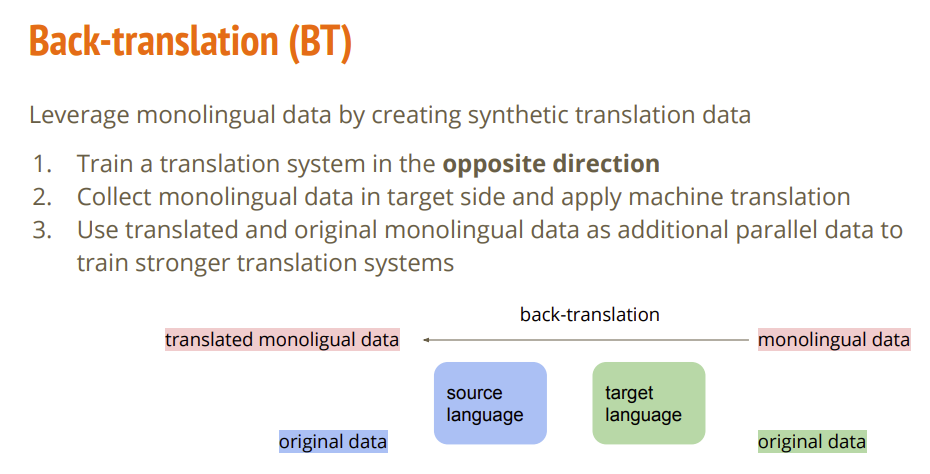

## 利用反向模型生成額外資料 (prepare_back_data.py)
### 下載 monolingual data

In [4]:
from prepare_back_data import download_data, clean_corpus, subword_units, binarize, \
                                generate_reverse_data, generate_dataset

lines = inspect.getsource(download_data)
print(lines)

def download_data(): 
    mono_prefix = Path(data_dir).absolute() / mono_dataset_name
    mono_prefix.mkdir(parents=True, exist_ok=True)

    urls = (
        # '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
    # If the above links die, use the following instead. 
        "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
    # # If the above links die, use the following instead. 
    #     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
    )
    file_names = (
        'ted_zh_corpus.deduped.gz',
    )

    for u, f in zip(urls, file_names):
        path = mono_prefix/f
        if not path.exists():
            if 'mega' in u:
                os.system(f"megadl {u} --path {path}")
            else:
                os.system(f"wget {u} -O {path}")
        else:
            print(f'{f} is exist, skip downloading')
        if path.suffix == ".tgz":
            os.syst

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [5]:
lines = inspect.getsource(clean_corpus)
print(lines)

def clean_corpus(mono_prefix, src_lang, ratio=9, max_len=1000, min_len=1):
    with open(f'{mono_prefix}/ted_zh_corpus.clean', 'w') as out_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as f:
            for line in f.readlines():
                line = line.strip()       
                s1 = clean_s(line, src_lang)
                s1_len = len_s(s1, src_lang)
                if min_len > 0: # remove short sentence
                    if s1_len < min_len:
                        continue
                if max_len > 0: # remove long sentence
                    if s1_len > max_len:
                        continue                   
                print(s1, file=out_f)



### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [6]:
lines = inspect.getsource(subword_units)
print(lines)

def subword_units(mono_prefix, src_lang, tgt_lang):
    vocab_size = 8000

    data_dir = "/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/"
    prefix = Path(data_dir).absolute() / "ted2020"

    spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))

    # already process 
    for lang in [src_lang]:
        out_path = mono_prefix/f'mono.tok.{lang}'
        # os.system(f"rm {out_path}")
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
                with open(mono_prefix/f'ted_zh_corpus.clean', 'r') as in_f:     
                    lines = in_f.readlines()             
                    for line in lines:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)
                    line_counts = len(l

### Binarize

使用fairseq將資料轉為binary

In [7]:
lines = inspect.getsource(binarize)
print(lines)

def binarize(mono_prefix):
    binpath = Path('./DATA/data-bin', mono_dataset_name)
    src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
    tgt_dict_file = src_dict_file
    monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization
    if binpath.exists():
        print(binpath, "exists, will not overwrite!")
    else:
        os.system(f"{config.python_path} -m fairseq_cli.preprocess \
            --source-lang 'zh'\
            --target-lang 'en'\
            --trainpref {monopref}\
            --destdir {binpath}\
            --srcdict {src_dict_file}\
            --tgtdict {tgt_dict_file}\
            --workers 2")



### TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [8]:
lines = inspect.getsource(generate_reverse_data)
print(lines)

def generate_reverse_data():    
    # 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
    # ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
    os.system(f"cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin")
    os.system(f"cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx")
    os.system(f"cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin")
    os.system(f"cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx")

    proj = "hw5.seq2seq"
    logger = logging.getLogger(proj)

    task = load_task(logger)

    model = build_model(arch_args, task)
    model = model.to(device=device)

    sequence_generator = task.build_generator([model], config)

    generate_prediction(model, task ,split="mono" ,outfile="./mono.en.txt", sequence_generator=sequence_generator)



### TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [9]:
lines = inspect.getsource(generate_dataset)
print(lines)

def generate_dataset(mono_prefix):
    # 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
    # 
    # hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
    vocab_size = 8000

    data_dir = "/home/leyan/Documents/Hung-yi-Lee/hw6_transformer/DATA/rawdata/"
    prefix = Path(data_dir).absolute() / "ted2020"

    # spm_model.encode(line, out_type=str)
    # output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh

    spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
    with open(f'{mono_prefix}/mono.finaltok.en', 'w') as out_f:
        with open('./mono.en.txt', 'r') as in_f:
            for line in in_f:
                line = line.strip()
                tok = spm_model.encode(line, out_type=str)
                print(' '.join(tok), file=out_f)

    os.system(f"cp {mono_prefix}/mono.tok.zh {mono_prefix}/mono.finaltok.zh")

    
    # hint: 在此用 fairseq 把這些檔案再 binarize
    binpath = Path('./DATA/data-bin/synthetic')
    src_dict_file = './DATA/data-bin/t

### TODO: 重新訓練 (back_translation_main.py)

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

In [10]:
# For Strong(Back-translation)
config = Namespace(
    python_path = "/home/leyan/anaconda3/envs/torch_1_21/bin/python",
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "./checkpoints/rnn-bt",  # strong
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

In [11]:
!python back_translation_main.py

2022-09-27 19:09:25 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2022-09-27 19:09:25 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2022-09-27 19:09:25 | INFO | hw5.seq2seq-bt | loading data for epoch 1
2022-09-27 19:09:25 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2022-09-27 19:09:25 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2022-09-27 19:09:25 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2022-09-27 19:09:25 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2022-09-27 19:09:25 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2022-09-27 19:09:25 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-z

# References

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html